<a href="https://colab.research.google.com/github/8Raouf24/PFE/blob/master/RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import gzip
import matplotlib.pyplot as plt
import json

We download our dataset representing items from Amazon belonging to the "Video Games" Category

In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games_5.json.gz

--2020-07-17 15:46:53--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154050105 (147M) [application/octet-stream]
Saving to: ‘Video_Games_5.json.gz.1’

Video_Games_5.json. 100%[===================>] 146.91M  21.5MB/s    in 7.7s    

2020-07-17 15:47:01 (19.0 MB/s) - ‘Video_Games_5.json.gz.1’ saved [154050105/154050105]



In [ ]:
### load the meta data

data = []
with gzip.open('Video_Games_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

497577
{'overall': 5.0, 'verified': True, 'reviewTime': '10 17, 2015', 'reviewerID': 'A1HP7NVNPFMA4N', 'asin': '0700026657', 'reviewerName': 'Ambrosia075', 'reviewText': "This game is a bit hard to get the hang of, but when you do it's great.", 'summary': "but when you do it's great.", 'unixReviewTime': 1445040000}


In [ ]:
df = pd.DataFrame.from_dict(data)
data_dict = {'userID':df['reviewerID'],'itemID':df['asin'],'rating':df['overall']}
df_rs = pd.DataFrame.from_dict(data_dict)
df = df_rs

print(df_rs.iloc[0])

userID    A1HP7NVNPFMA4N
itemID        0700026657
rating                 5
Name: 0, dtype: object


We do some preprocessings to encode the users and items as integer indices

In [ ]:
user_ids = df_rs["userID"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
item_ids = df_rs["itemID"].unique().tolist()
item2item_encoded = {x: i for i, x in enumerate(item_ids)}
item_encoded2item = {i: x for i, x in enumerate(item_ids)}
df_rs["user"] = df_rs["userID"].map(user2user_encoded)
df_rs["item"] = df_rs["itemID"].map(item2item_encoded)

num_users = len(user2user_encoded)
num_items = len(item_encoded2item)
df_rs["rating"] = df_rs["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df_rs["rating"])
max_rating = max(df_rs["rating"])

print(
    "Number of users: {}, Number of Items: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_items, min_rating, max_rating
    )
)


Number of users: 55223, Number of Items: 17408, Min rating: 1.0, Max rating: 5.0


We prepare the training and validation data

In [ ]:
df_rs = df_rs.sample(frac=1, random_state=42)
x = df_rs[["user", "item"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df_rs["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.8 * df_rs.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)


We create the model by embedding both user's and item's vector into a 50-dimensional vectors.
The model computes a match score between user and movie embeddings via a dot product, and adds a per-item and per-user bias. The match score is scaled to the [0, 1] interval via a sigmoid (since our ratings are normalized to this range).  

In [ ]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.item_embedding = layers.Embedding(
            num_items,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.item_bias = layers.Embedding(num_items, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        x = dot_user_item + user_bias + item_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_items, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.0001),
     metrics=[tf.keras.metrics.RootMeanSquaredError()])


We train our model on the data split 

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=50,
    verbose=1,
    validation_data=(x_val, y_val),
)


Epoch 1/50
6220/6220 [==============================] - 165s 26ms/step - loss: 0.6783 - root_mean_squared_error: 0.4164 - val_loss: 0.6476 - val_root_mean_squared_error: 0.3977
Epoch 2/50
6220/6220 [==============================] - 166s 27ms/step - loss: 0.5424 - root_mean_squared_error: 0.3295 - val_loss: 0.4977 - val_root_mean_squared_error: 0.2988
Epoch 3/50
6220/6220 [==============================] - 165s 27ms/step - loss: 0.4882 - root_mean_squared_error: 0.2931 - val_loss: 0.4965 - val_root_mean_squared_error: 0.2979
Epoch 4/50
6220/6220 [==============================] - 165s 27ms/step - loss: 0.4838 - root_mean_squared_error: 0.2906 - val_loss: 0.4926 - val_root_mean_squared_error: 0.2954
Epoch 5/50
6220/6220 [==============================] - 167s 27ms/step - loss: 0.4798 - root_mean_squared_error: 0.2883 - val_loss: 0.4901 - val_root_mean_squared_error: 0.2937
Epoch 6/50
6220/6220 [==============================] - 166s 27ms/step - loss: 0.4763 - root_mean_squared_error: 0.

PLot training , and validation rmse

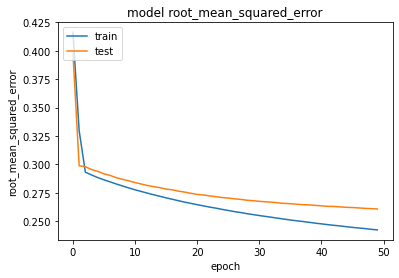

In [ ]:
plt.plot(history.history["root_mean_squared_error"])
plt.plot(history.history["val_root_mean_squared_error"])
plt.title("model root_mean_squared_error")
plt.ylabel("root_mean_squared_error")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()